# Unfolding with RooUnfold 2: Regularisation

In [1]:
import ROOT

In file included from input_line_33:1:
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/dlfcn.h:64:37: warning: unknown platform 'driverkit' in availability macro [-Wavailability]
extern int dlclose(void * __handle) __DYLDDL_DRIVERKIT_UNAVAILABLE;
                                    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/dlfcn.h:44:41: note: expanded from macro '__DYLDDL_DRIVERKIT_UNAVAILABLE'
 #define __DYLDDL_DRIVERKIT_UNAVAILABLE __API_UNAVAILABLE(driverkit)
                                        ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/Availability.h:419:190: note: expanded from macro '__API_UNAVAILABLE'
    #define __API_UNAVAILABLE(...) __API_UNAVAILABLE_GET_MACRO(__VA_ARGS__,__API_UNAVAILABLE7,__API_UNAVAILABLE6,__API_UNAVAILABLE5,__API_UNAVAILABLE4,__API_UNAVAILABLE3,__API_UNAVAILABLE2,__API_UNAVAILABLE1, 0)(__VA_ARGS__)
                                                                                           

Welcome to JupyROOT 6.26/04


## Why are there so many methods?

In the prievious excercise several methods for unfolding were presented, together with the Riemann-Lebesgue Lemma.

First let us try to understand the nature of this problem.
Here we begin with a smearing function as before but this time we use a more physics based example. A Calorimeter resolution. The response function is smeared not with a flat gaussian but as a gaussian with the following width.
$$
\sigma_\textrm{calo} = E\left(\frac{a}{\sqrt{E}}+\frac{b}{E}+c\right)
$$
Where $a$ is called the stocastic term and includes all the intrisic fluctuations of the partcle shower (the process with which we use calorimeters to measure the energy of particles in our detector. The second term $b$ is know as the noise term and relates to the performance of the detector itself. The final term $c$ is a constant term and as such can be moved into the mean of the smearing (or ingnored completly as it has no impact on unfolding performance) further more we include a quadratic efficiency term instead of a linear one.

In [2]:
def CaloSmear(xt, xmin, xmax, a, b, c):
    # calculate efficiency
    diff = xmax - xmin
    center = xmin + diff/2
    xeff = 0.1 + 0.7 * (1 - ((center - xt)/diff)**2 )

    x = ROOT.gRandom.Rndm()
    if x>xeff: 
        return None
    
    sigma_x = xt * (a/ROOT.TMath.Sqrt(xt)) + b
    xsmear = ROOT.gRandom.Gaus(c, sigma_x)

    return xt + xsmear

In [3]:
f0 = ROOT.TH1D("f0","f0",40,0,10)
g0 = ROOT.TH1D("g0","g0",40,0,10)
response = ROOT.RooUnfoldResponse (40, 0, 10.0)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



As before we train our response with a Breit-Wigner with mean 0.3 and width 2.5.

In [4]:
for i in range(100000):
  xt = ROOT.gRandom.BreitWigner(5.0, 1.0)
  f0.Fill(xt)
  x = CaloSmear(xt, 0, 10, .15, .1, -1.25)
  if x!=None:
    response.Fill(x, xt)
    g0.Fill(x)
  else:
    response.Miss(xt)

Once again the response function is populated through the use of the `Fill` and `Miss` functions. Note in comparison to the last example the range now goes from 0 to 10 rather than -10 to 10 due to the square root in the energy resolution caluclation. Below we see tha the distributions look very similar to before.

Info in <TCanvas::Print>: png file calo-true-response.png has been created


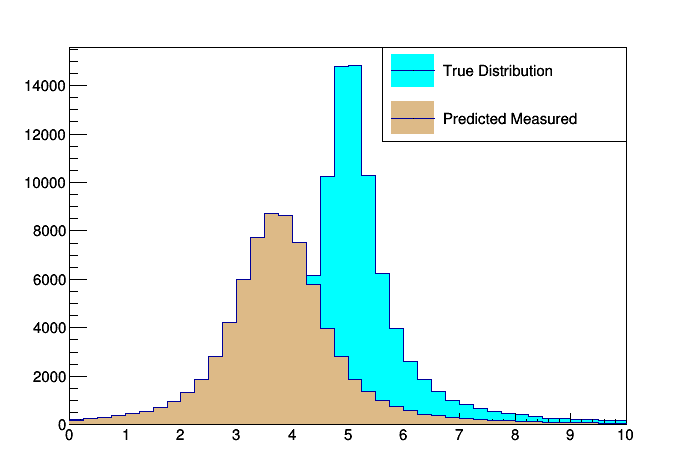

In [5]:
c = ROOT.TCanvas()
f0.SetStats(0)
f0.SetTitle("")
f0.SetFillColor(7)
f0.Draw()
g0.SetFillColor(42)
g0.Draw("same")
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(f0,"True Distribution")
leg.AddEntry(g0,"Predicted Measured")
leg.Draw()
c.Draw()
c.SaveAs("calo-true-response.png");

However if we would like to visualise the respone we can see that this construction has many more off diagonal elements. These elements, depending on how they arise, correspond to the arbrartary spikes in the true distribution that blow up during unfolding.

Info in <TCanvas::Print>: png file calo-response.png has been created


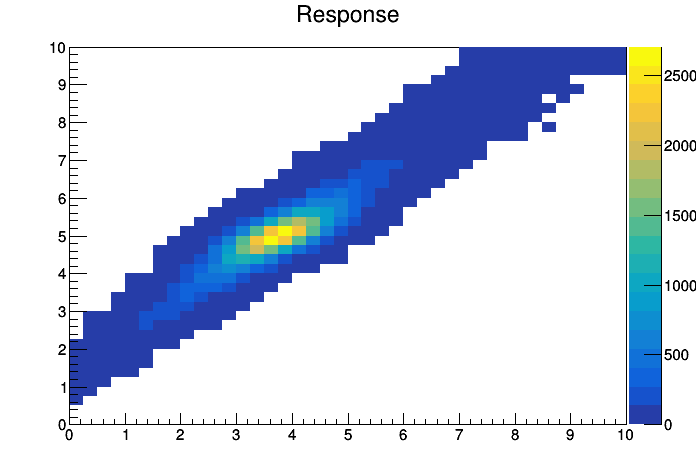

In [6]:
R = response.HresponseNoOverflow()
c1 = ROOT.TCanvas()
R.SetStats(0)
R.Draw("colz")
c1.Draw()
c1.SaveAs('calo-response.png')

Lets see how this works on our gaussian!

In [7]:
hTrue = ROOT.TH1D ("true", "Test Truth",    40, 0, 10.0);
hMeas = ROOT.TH1D ("meas", "Test Measured", 40, 0, 10.0);
#  Test with a Gaussian, mean 5 and width 1.
for i in range(10000):
    xt = ROOT.gRandom.Gaus (5.0, 1.0)
    x = CaloSmear(xt, 0, 10, .15, .1, -1.25)
    hTrue.Fill(xt)
    if x != None: hMeas.Fill(x)

First lets see how this works on our Naive matrix inversion

In [8]:
unfold = ROOT.RooUnfoldInvert(response, hMeas)
hReco = unfold.Hunfold()

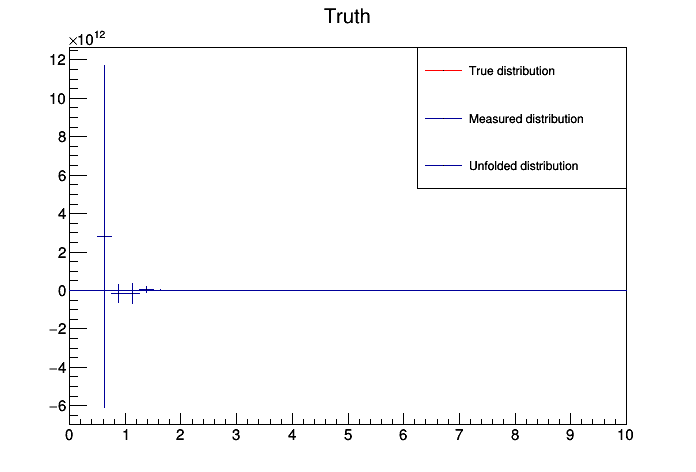

In [9]:
c1 = ROOT.TCanvas()
hReco.SetStats(0)
hTrue.SetLineColor(2)
hReco.Draw()
hTrue.Draw("same")
hMeas.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrue, "True distribution","pl")
leg.AddEntry(hMeas, "Measured distribution", "pl")
leg.AddEntry(hMeas, "Unfolded distribution")
leg.Draw()
c1.Draw()

Oh not so good! But this is what unfolding is all about.

## SVD as a tool for understanding our Response Matrix

Let's us go back to our problem formulation. 
$$
\hat{\mu}=R^{-1}\bf{n}
$$
Here we use a square matrix for the response. Square matrices, if full rank, are typically invertable. However typically an estimate for the inverse of any matrix can be found using iterative methods even with non-square matrices. This estimate is called the pseudoinverse and it is typically done using singular value decomposition.

The response matrix is decomposed into $n$ components with $n$ being the number of bins in the reconstructed distribution. The speed with which the coeficients of these components go to zero is precicely the sensitivity with which fluctuations in the data cause the variance of the estimators to explode with smaller components (coeficients approaching zero) causing the largest effect.

As described in the last excercise the tSVD method truncates these smaller components before returning the inverted matrix.

Here we make a gif to show the effect of changing the number of components.

In [11]:
import imageio

remember 40 is all of the components, 10 is a quarter of them.

In [12]:
n_singular_values = [40,30,20]+list(range(1,16))[::-1]
images = []
for n in n_singular_values:
    unfold = ROOT.RooUnfoldSvd(response, hMeas, n)
    hReco = unfold.Hunfold()
    c1 = ROOT.TCanvas()
    hReco.SetStats(0)
    hTrue.SetLineColor(2)
    hReco.Draw()
    if n < 20: hReco.GetYaxis().SetRangeUser(0,1800)
    hTrue.Draw("same")
    hMeas.Draw("same")
    leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
    leg.AddEntry(hTrue, "True distribution","pl")
    leg.AddEntry(hMeas, "Measured distribution", "pl")
    leg.AddEntry(hMeas, "Unfolded {} components".format(n))
    leg.Draw()
    filename = "svd{}.png".format(n)
    c1.SaveAs(filename);
    images.append(imageio.imread(filename))
imageio.mimsave('svd.gif', images+images[::-1], duration=.75)

/var/folders/3w/jcz46dj964526sk_kgkg8p0r0000gn/T/ipykernel_25621/4283501138.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


SVD init 40 x 40 bins, kreg=40
SVD init 40 x 40 bins, kreg=30
SVD init 40 x 40 bins, kreg=20
SVD init 40 x 40 bins, kreg=15
SVD init 40 x 40 bins, kreg=14
SVD init 40 x 40 bins, kreg=13
SVD init 40 x 40 bins, kreg=12
SVD init 40 x 40 bins, kreg=11
SVD init 40 x 40 bins, kreg=10
SVD init 40 x 40 bins, kreg=9
SVD init 40 x 40 bins, kreg=8
SVD init 40 x 40 bins, kreg=7
SVD init 40 x 40 bins, kreg=6
SVD init 40 x 40 bins, kreg=5
SVD init 40 x 40 bins, kreg=4
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=1


Info in <TCanvas::Print>: png file svd40.png has been created
Info in <TCanvas::Print>: png file svd30.png has been created
Info in <TCanvas::Print>: png file svd20.png has been created
Info in <TCanvas::Print>: png file svd15.png has been created
Info in <TCanvas::Print>: png file svd14.png has been created
Info in <TCanvas::Print>: png file svd13.png has been created
Info in <TCanvas::Print>: png file svd12.png has been created
Info in <TCanvas::Print>: png file svd11.png has been created
Info in <TCanvas::Print>: png file svd10.png has been created
Info in <TCanvas::Print>: png file svd9.png has been created
Info in <TCanvas::Print>: png file svd8.png has been created
Info in <TCanvas::Print>: png file svd7.png has been created
Info in <TCanvas::Print>: png file svd6.png has been created
Info in <TCanvas::Print>: png file svd5.png has been created
Info in <TCanvas::Print>: png file svd4.png has been created
Info in <TCanvas::Print>: png file svd3.png has been created
Info in <TCanva

![](./svd.gif)

There are several things to see here. As expected from our deep understanding of the reimann-lebesgue lemma, the naive inversion including all the off diagonal elements gives us massive fluctuations in the unfolded spectrum. Whereas for the low numbers of components all we get is the original breit-wigner and none of the data. 

This directly demonstrates the bias-variance trade-off described previously. Strong regularisation biases us towards our training dataset (in this case the breit-wigner), whereas a lack of regularisation allows our variance to blow up.

## Other methods

Iterative methods such as the Richardson Lucy method implemented in RooUnfold as 'Bayes' in many cases have become the standard method for regularised unfolding. This is due to several desirable properties of the method. The iterative method does not rely on the rank of the input matrix and is (in general) much more stable when dealing with very large numbers of bins. If the input/training distribution is very similar to the data the algorithm converges very quickly and with very little noticable bias. When the algorithm converges it takes a lot of additional iterations to give the extreme fluctuations seen in the SVD approach. Normally we see the distributions match up in 3-4 iterations then all that changes are the size of the error bars, meaning the extreme cases like above are never considered.

In [12]:
n_bayes = list(range(1,11))+[10+i*2 for i in list(range(1,5))]+[20,50,100,800]
images = []
for n in n_bayes:
    unfold = ROOT.RooUnfoldBayes(response, hMeas, n)
    hReco = unfold.Hunfold()
    c1 = ROOT.TCanvas()
    hReco.SetStats(0)
    hTrue.SetLineColor(2)
    hReco.Draw()
    if n < 800: hReco.GetYaxis().SetRangeUser(0,1800)
    #else: hReco.GetYaxis().SetRangeUser(0,1800)
    hTrue.Draw("same")
    hMeas.Draw("same")
    leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
    leg.AddEntry(hTrue, "True distribution","pl")
    leg.AddEntry(hMeas, "Measured distribution", "pl")
    leg.AddEntry(hMeas, "Unfolded {} iterations".format(n))
    leg.Draw()
    filename = "bayes{}.png".format(n)
    c1.SaveAs(filename);
    images.append(imageio.imread(filename))
imageio.mimsave('bayes.gif', images+images[::-1], duration=.75)

Now unfolding...
Iteration : 0
Chi^2 of change 424.095
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 424.095
Iteration : 1
Chi^2 of change 56.6913
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 424.095
Iteration : 1
Chi^2 of change 56.6913
Iteration : 2
Chi^2 of change 16.5133
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 424.095
Iteration : 1
Chi^2 of change 56.6913
Iteration : 2
Chi^2 of change 16.5133
Iteration : 3
Chi^2 of change 6.16226
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 424.095
Iteration : 1
Chi^2 of change 56.6913
Iteration : 2
Chi^2 of change 16.5133
Iteration : 3
Chi^2 of change 6.16226
Iteration : 4
Chi^2 of change 2.77248
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 424.095
Itera

Info in <TCanvas::Print>: png file bayes1.png has been created
Info in <TCanvas::Print>: png file bayes2.png has been created
Info in <TCanvas::Print>: png file bayes3.png has been created
Info in <TCanvas::Print>: png file bayes4.png has been created
Info in <TCanvas::Print>: png file bayes5.png has been created
Info in <TCanvas::Print>: png file bayes6.png has been created
Info in <TCanvas::Print>: png file bayes7.png has been created
Info in <TCanvas::Print>: png file bayes8.png has been created
Info in <TCanvas::Print>: png file bayes9.png has been created
Info in <TCanvas::Print>: png file bayes10.png has been created
Info in <TCanvas::Print>: png file bayes12.png has been created
Info in <TCanvas::Print>: png file bayes14.png has been created
Info in <TCanvas::Print>: png file bayes16.png has been created
Info in <TCanvas::Print>: png file bayes18.png has been created
Info in <TCanvas::Print>: png file bayes20.png has been created
Info in <TCanvas::Print>: png file bayes50.png ha

![](bayes.gif)

Looking at the output we can note the benefits of the method, it recovers a good facimily to the truth distribution very quickly and the errors are consitently small. Even at very low number of iterations the data and truth distributions look fairly similar. However a more subtle point is that the bias between training and data distributions is visible in the peak of the distribution for a long time which might not be visible if the distributions were more similar. In the tikonov (TUnfold) and tSVD approaches there are various mathematical tools such as the L-curve with which to choose your regularisation parameter. Here this has to be done by eye and depends a lot on how similar your distributions may be.